In [0]:
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from scipy import sparse
import gzip
import networkx as nx
from networkx import gnp_random_graph
from networkx import adjacency_matrix
from networkx import barabasi_albert_graph as ba
from collections import defaultdict
from random import random
from random import randint
from collections import Counter
from random import shuffle
from scipy import sparse as sp
import random
from scipy import stats
from collections import defaultdict
import powerlaw as pl

## Functions of generating BA, ER, WS and configuration networks.
## SIR and SEIR implemented on input networks

In [0]:

def sir_network(A,I0,beta,mu,T,rep=10):
    N = A.shape[0]
    S = np.zeros((T,rep))
    I = np.zeros((T,rep))
    R = np.zeros((T,rep))
    
    S[0,:] = N-I0
    I[0,:] = I0
    R[0,:] = 0
    
    
    for r in range(rep):
        node_status = {node:{'current_status':'S', 'next_status':None} for node in range(N)}


        init_infected = np.random.permutation(N)[:I0]
        for node in init_infected:
            node_status[node]['current_status'] = 'I'

        for t in range(1,T):
            S[t,r] = S[t-1,r]
            I[t,r] = I[t-1,r]
            R[t,r] = R[t-1,r]
            for node in range(N):
                if node_status[node]['current_status']=='S':
                    for neigh in A[node].indices:
                        if node_status[neigh]['current_status']=='I':
                            if np.random.rand()<beta:
                                node_status[node]['next_status']='I'
                                S[t,r] -= 1
                                I[t,r] += 1
                                break
                elif node_status[node]['current_status']=='I':
                    if np.random.rand()<mu:
                        node_status[node]['next_status']='R'
                        R[t,r] += 1
                        I[t,r] -= 1

            for node in range(N):
                if node_status[node]['next_status']:
                    node_status[node]['current_status'] = node_status[node]['next_status']
                    node_status[node]['next_status'] = None

    return S,I,R



def configuration_model(degrees):
    if degrees.sum()%2 != 0:
        degrees[np.argmax(degrees)] += 1
        
    #stubs = []
    #for node, k in enumerate(degrees):
    #    stubs +=[node]*k   
    stubs = [node for node,k in enumerate(degrees) for __ in range(k)]
    shuffle(stubs)
    
    w_edges = Counter(zip(stubs[0::2],stubs[1::2]))
    nodes_i, nodes_j = zip(*w_edges.keys())
    values = list(w_edges.values())

    A = sp.csr_matrix((values*2, (nodes_i+nodes_j, nodes_j+nodes_i)))

    return A

def ER(N,p, implementation = 1, verbose = True):
    if implementation == 0:
        if verbose: print('using 2 nested for-loops')
        from random import random
        A = np.zeros((N,N))
        for row in range(N):
            for col in range(row+1,N):
                if random()<p:
                    A[row,col] = 1
                    A[col,row] = 1
    elif implementation==1:
        A = np.zeros((N,N), dtype=int)
        rows, cols = np.triu_indices(n=N,m=N,k=1)
        L = len(rows)
        rands = np.random.rand(L)        
        A[rows,cols] = rands<p
        A[cols,rows] = rands<p
    return csr_matrix(A)


def WattsStrogatz(N,k,p):
    if k%2 != 0:
        raise NameError('Wrong average degree')
        
    nodes = list(range(N))
    
    # This is the ring
    links = []
    for m in range(1,k//2+1):
        shifted_nodes = nodes[m:] + nodes[0:m]
        links += list(zip(nodes,shifted_nodes))
        
    from random import choice
    # Rewiring step                        
    for m in range(1,k//2+1):
        shifted_nodes = nodes[m:] + nodes[0:m]
        for node_i in nodes:
            node_j = shifted_nodes[node_i]
            if random.random()<p:
                rewired_node_j = choice(nodes)
                new_edge = (node_i,rewired_node_j)
                
                while (new_edge in links) or (new_edge[::-1] in links) or (rewired_node_j==node_i):
                    rewired_node_j = choice(nodes)
                    new_edge = (node_i,rewired_node_j)
                    if sum(map(lambda x:x.count(node_i),links)) == N-1:
                        print('Rewiring impossible for node: %s [edge (%s,%s)]' % (node_i, node_i, node_j))
                        break
                else:
                    # Executed only if "break" does not occur
                    links.remove((node_i,node_j))
                    links.append(new_edge)
                            
    # Fill adjacency matrix                
    rows, cols = zip(*links)
    ones = np.ones(2*len(rows))
    A = csr_matrix((ones,(rows+cols,cols+rows)), shape=(len(nodes),len(nodes)))
    return A


def seir_network(A,I0,beta,sigma,mu,d,eta,T):
    N = A.shape[0]
    S = np.zeros(T+1)
    E = np.zeros(T+1)
    I = np.zeros(T+1)
    R = np.zeros(T+1)

    S[0] = N-I0
    I[0] = I0    
      
    node_status = {node:{'current_status':'S', 'next_status':None} for node in range(N)}
    
    init_infected = np.random.permutation(N)[:I0]
    for node in init_infected:
        node_status[node]['current_status'] = 'I'
        
    for t in range(1,T+1):
        S[t] = S[t-1]
        E[t] = E[t-1]
        I[t] = I[t-1]
        R[t] = R[t-1]
        for node in range(N):
            if node_status[node]['current_status']=='S':
                for neigh in A[node].indices:
                    if node_status[neigh]['current_status']=='I':
                        if np.random.rand()<beta:
                            node_status[node]['next_status']='E'
                            S[t] -= 1
                            E[t] += 1
                            break
            elif node_status[node]['current_status']=='E':
                if np.random.rand()<sigma:
                    node_status[node]['next_status']='I'
                    I[t] += 1
                    E[t] -= 1
            elif node_status[node]['current_status']=='I':
                rand=np.random.rand()
                if rand<mu:
                    node_status[node]['next_status']='R'
                    I[t] -= 1
                    R[t] += 1     
                elif rand<mu+d:
                    node_status[node]['next_status']='D'
                    I[t] -= 1
            elif node_status[node]['current_status']=='R':
                if np.random.rand()<eta:
                    node_status[node]['next_status']='S'
                    S[t] += 1
                    R[t] -= 1     


        for node in range(N):
            if node_status[node]['next_status']:
                node_status[node]['current_status'] = node_status[node]['next_status']
                node_status[node]['next_status'] = None

                    
    return S,E,I,R
 

        

def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]


In [8]:
N = 1000
A_ba = nx.adjacency_matrix(nx.barabasi_albert_graph(N,3))
#G = gnp_random_graph(50, 0.2)
#A = nx.adjacency_matrix(G)
I0 = 10
T = 30
beta = 0.2
mu = 0.05
S_ba,I_ba,R_ba = sir_network(A_ba,I0,beta,mu,T,rep=20)
print(np.shape(S_ba))

(30, 20)


## **Visualisation of the adjacency matrix of the barabasi-albert network**




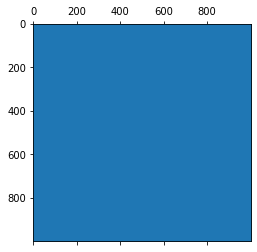

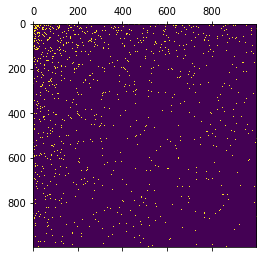

In [0]:
plt.spy(A_ba.astype(bool))
plt.matshow(A_ba.astype(bool).todense())

Text(0.5, 1.0, 'SIR implemented on BA networks with 95% CI ')

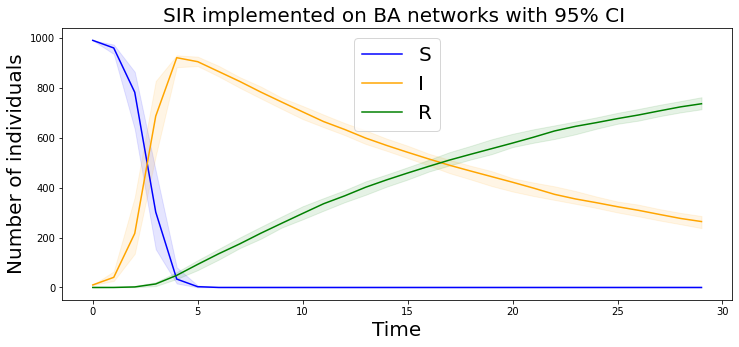

In [0]:
S,I,R=S_ba,I_ba,R_ba
fig, axs = plt.subplots(1,figsize=(12,5))
axs.plot(np.median(S,axis=1), label='S', color='blue')
axs.plot(np.median(I,axis=1), label='I',  color='orange')
axs.plot(np.median(R,axis=1), label='R',  color='green')
time = np.arange(S.shape[0])
axs.fill_between(time, np.percentile(S,2.5,axis=1), np.percentile(S,97.5,axis=1), color='blue', alpha=0.10)
axs.fill_between(time, np.percentile(I,2.5,axis=1), np.percentile(I,97.5,axis=1), color='orange', alpha=0.10)
axs.fill_between(time, np.percentile(R,2.5,axis=1), np.percentile(R,97.5,axis=1), color='green', alpha=0.10)
axs.set_xlabel('Time', fontsize=20)
axs.set_ylabel('Number of individuals', fontsize=20)
axs.legend(fontsize=20)
axs.set_title('SIR implemented on BA networks with 95% CI ', fontsize=20)




## **comparing and contrasting beta**

In [0]:
def get_degrees(A, is_directed = False, degree_type = 'total'):
    if is_directed:
        if degree_type == 'total':
            degrees = np.asarray(A.sum(axis=0)).reshape(-1)
            degrees += np.asarray(A.sum(axis=1)).reshape(-1)
        elif degree_type == 'in':
            degrees = np.asarray(A.sum(axis=0)).reshape(-1) # sum over the rows
        elif degree_type == 'out':
            degrees = np.asarray(A.sum(axis=1)).reshape(-1) # sum over the columns
    else:
        degrees = np.asarray(A.sum(axis=0)).reshape(-1)
    return degrees

deg_ba=get_degrees(A_ba)



/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


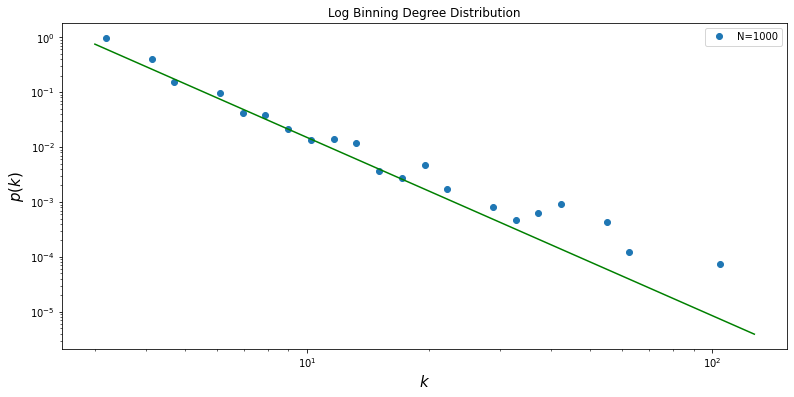

In [10]:

def powerplot(degList,nbins=30):
    fig =plt.figure(figsize=(13,6))
    x_max=np.log10(max(degList))
    x_min=np.log10(min(degList))
    bins=np.log10(np.logspace(x_min,x_max,nbins))
    widths = (bins[1:] - bins[:-1])
    x= 10**((bins[1:]+bins[:-1])/2)
    y=np.histogram(degList,bins=np.logspace(x_min,x_max,30),density=True)[0]
    plt.loglog(x,y,'o',label="N=%d" %len(degList))
    fit=pl.Fit(degList,xmin=min(degList),xmax=max(degList)) 
     
    fit.power_law.plot_pdf(color='g') 

    plt.xlabel("$k$", fontsize=15)
    plt.ylabel("$p(k)$", fontsize=15)
    plt.title('Log Binning Degree Distribution')
    plt.legend()    

    return fit.alpha  


power_ba=powerplot(deg_ba,nbins=30)

In [0]:
def plot_CI_beta(A,num_beta,N,I0,beta_multiple,mu,T,rep=10):
    deg=get_degrees(A)
    kmean=np.mean(deg)
    #input beta as the multiples of mu/kmean
    
    fig, axs = plt.subplots(num_beta,sharex=True,sharey=True,figsize=(10,16))
    
    for i in range(num_beta):
        S,I,R =  sir_network(A,I0,beta_multiple[i]*mu/kmean,mu,T,rep=10)
        axs[i].plot(np.median(S,axis=1),  lw=5, color='blue')
        axs[i].plot(np.median(I,axis=1), label='beta=(mu/<k>)*%.1f,mu=%.1f'%(beta_multiple[i],mu), lw=5, color='orange')
        axs[i].plot(np.median(R,axis=1), lw=5, color='green')
        time = np.arange(S.shape[0])

        axs[i].fill_between(time, np.percentile(S,2.5,axis=1), np.percentile(S,97.5,axis=1), color='blue', alpha=0.10)
        axs[i].fill_between(time, np.percentile(I,2.5,axis=1), np.percentile(I,97.5,axis=1), color='orange', alpha=0.10)
        axs[i].fill_between(time, np.percentile(R,2.5,axis=1), np.percentile(R,97.5,axis=1), color='green', alpha=0.10)
        axs[i].legend(fontsize=15)
    fig.text(0.5, 0.04, 'Time', ha='center',fontsize=20)
    fig.text(0.04, 0.5, 'Number of Infected Individuals', va='center', rotation='vertical',fontsize=20)
    return 



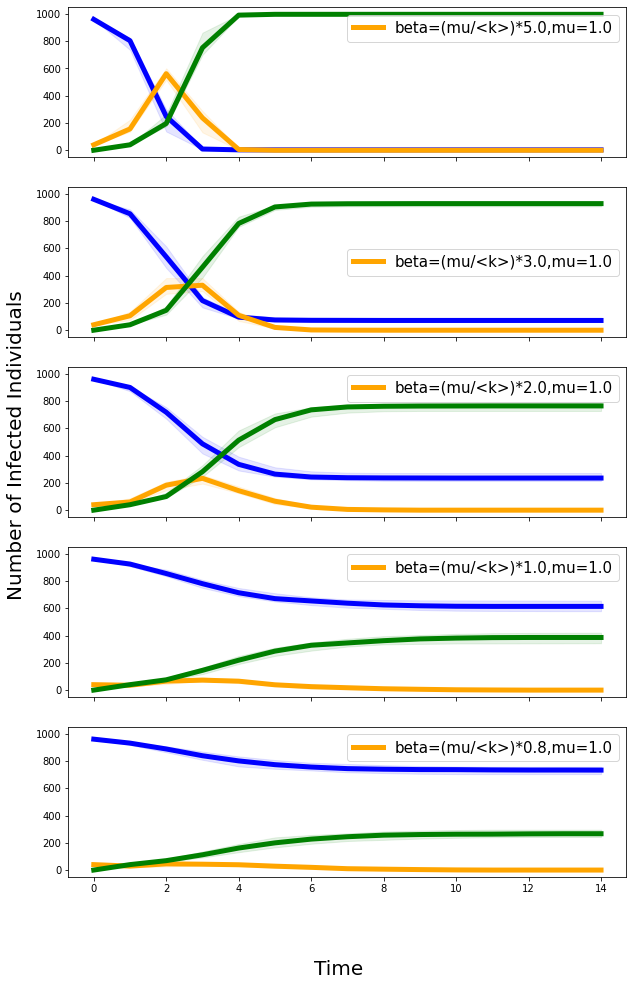

In [14]:
A_ba = nx.adjacency_matrix(nx.barabasi_albert_graph(N,3))
T=15
I0=40
N = 1000
mu=1
beta_multiple = [5,3,2,1,0.8]
num_beta=len(beta_multiple)
rep=10
plot_CI_beta(A_ba,num_beta,N,I0,beta_multiple,mu,T,rep)

## **Interpretation of the parameters**
## **We used estimation of covid19 parameters by AJ Kucharski**
https://www.thelancet.com/journals/laninf/article/PIIS1473-3099(20)30144-4/fulltext

* beta infection rate; 
* sigma rate of progression (inverse of incubation period);
* γ: rate of recovery (inverse of infectious period)
* ξ: rate of re-susceptibility (inverse of temporary immunity period; 0 if permanent immunity)
* d: rate of mortality from the disease (deaths per infectious individual per time)
* eta: rate of re-susceptibility (inverse of temporary immunity period; 0 if permanent immunity


In [16]:
N=10000
I0=10
beta=0.155
sigma=1/5.2
mu=1/12.39
T=30
A_ba = nx.adjacency_matrix(nx.barabasi_albert_graph(N,10))
S_ba,I_ba,R_ba = sir_network(A_ba,I0,beta,mu,T,rep=20)
print(np.shape(S_ba))

(30, 20)


In [0]:
deg_ba=get_degrees(A_ba)
A_config=configuration_model(deg_ba)

In [18]:
p=sum(deg_ba)/(N*(N-1))
print(p)
A_ER=ER(N, p)

0.001998199819981998


In [19]:
deg_ER=get_degrees(A_ER)
deg_config=get_degrees(A_config)

print(sum(deg_ER))
print(sum(deg_ba))
print(sum(deg_config))



199556
199800
199800


## **Generate a network using the Erdos-Renyi model that approximately preserves the total number of edges. And then we compare their distributions through some visualisations.**


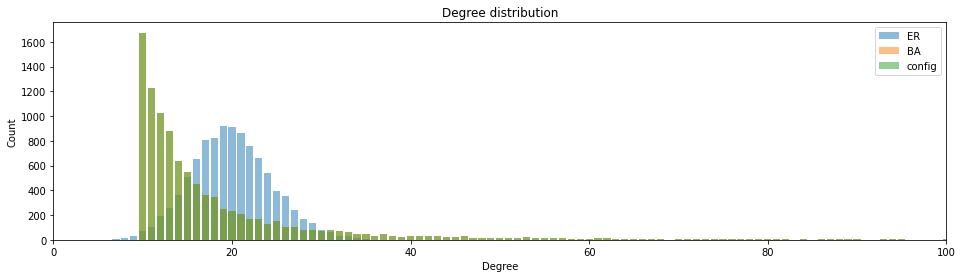

In [20]:
ER_unique, ER_counts = np.unique(deg_ER, return_counts=True)
ba_unique, ba_counts = np.unique(deg_ba, return_counts=True)
config_unique, config_counts = np.unique(deg_config, return_counts=True)

fig, ax = plt.subplots(figsize=(16,4))
ax.bar(ER_unique, ER_counts, align='center', alpha=0.5,label="ER")
ax.bar(ba_unique, ba_counts, align='center', alpha=0.5,label="BA")
ax.bar(config_unique, config_counts, align='center', alpha=0.5,label="config")

ax.set_xlabel('Degree')
ax.set_ylabel('Count')
ax.set_xlim(0,100)
ax.set_title('Degree distribution')

ax.legend()
plt.show()

## Same plot on a loglog scale, demonstrates power-law for the BA network


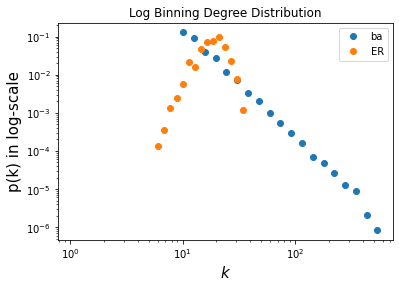

In [21]:
def degree_plot(degList,label):
    for i in range(len(degList)):
        if degList[i]==0:
            degList[i]=1
    #Get rid of the zeros for log-binning
    x_max=np.log10(max(degList))
    x_min=np.log10(1)
    bins=np.log10(np.logspace(x_min,x_max,30))
    widths = (bins[1:] - bins[:-1])
    x= 10**((bins[1:]+bins[:-1])/2)
    y=np.histogram(degList,bins=np.logspace(x_min,x_max,30),density=True)[0]
    plt.loglog(x,y,'o',label=label)
    plt.xlabel("$k$", fontsize=15)
    plt.ylabel("p(k) in log-scale", fontsize=15)
    plt.title('Log Binning Degree Distribution')
    plt.legend()
    return
degree_plot(list(deg_ba),'ba')
degree_plot(list(deg_ER),'ER')

## **Generate the configuration model of the BA network, preserving its degree sequence/ distribution. The generating process of the configuration model could be described as the following, assign stubs/ half-edges to the vertices according to the given degree sequence. Construct the edges by connecting the half-edges/stubs uniformly at random repetitively.**

In [0]:
S_ER,I_ER,R_ER=sir_network(A_ER,I0,beta,mu,T)
S_config,I_config,R_config=sir_network(A_config,I0,beta,mu,T)

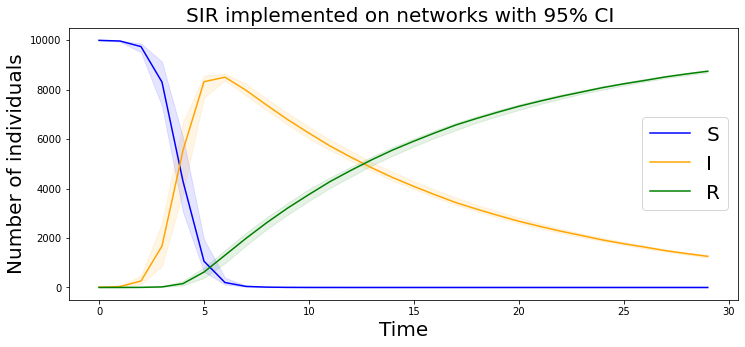

In [23]:
def sir_plot(S,I,R,rep):
  fig, axs = plt.subplots(1,figsize=(12,5))
  axs.plot(np.median(S,axis=1), label='S', color='blue')
  axs.plot(np.median(I,axis=1), label='I',  color='orange')
  axs.plot(np.median(R,axis=1), label='R',  color='green')
  time = np.arange(S.shape[0])
  axs.fill_between(time, np.percentile(S,2.5,axis=1), np.percentile(S,97.5,axis=1), color='blue', alpha=0.10)
  axs.fill_between(time, np.percentile(I,2.5,axis=1), np.percentile(I,97.5,axis=1), color='orange', alpha=0.10)
  axs.fill_between(time, np.percentile(R,2.5,axis=1), np.percentile(R,97.5,axis=1), color='green', alpha=0.10)
  axs.set_xlabel('Time', fontsize=20)
  axs.set_ylabel('Number of individuals', fontsize=20)
  axs.legend(fontsize=20)
  axs.set_title('SIR implemented on networks with 95% CI ', fontsize=20)
  return
sir_plot(S_ba,I_ba,R_ba,20)


## SIR on an Erdos-Renyi networks

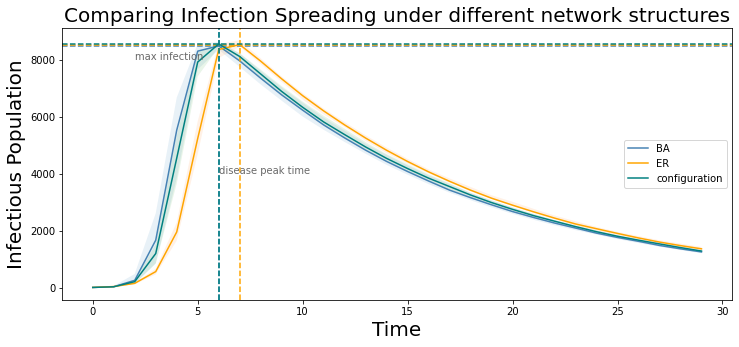

In [24]:
## This function could be used to compare lists of infected cases time series

def Infection_compare_plot(Infection_list,label_list,color_list,title='Comparing Infection Spreading under different network structures',text_control='off'):
    fig, axs = plt.subplots(1,figsize=(12,5))
    L=len(label_list)
    time = np.arange(Infection_list[0].shape[0])
    for i in range(L):
        axs.plot(np.median(Infection_list[i],axis=1), label=label_list[i],color=color_list[i])
        axs.axhline(max(np.median(Infection_list[i],axis=1)),ls='--',color=color_list[i])
        axs.axvline(np.argmax(np.median(Infection_list[i],axis=1)),ls='--',color=color_list[i])
        axs.fill_between(time, np.percentile(Infection_list[i],2.5,axis=1), np.percentile(Infection_list[i],97.5,axis=1), alpha=.1)
    if text_control=='on':
        
        axs.text(y=8000, x=2, s='max infection', alpha=2, color='dimgrey')
        axs.text(x=np.argmax(np.mean(Infection_list[i],axis=1)),y=4000, s='disease peak time', alpha=2, color='dimgrey')

    axs.set_xlabel('Time', fontsize=20)
    axs.set_ylabel('Infectious Population', fontsize=20)
    axs.legend(fontsize=10)
    axs.set_title(title, fontsize=20)
    return


Infection_list=[I_ba,I_ER,I_config]
label_list=['BA','ER','configuration']
color_list=['steelblue','orange','teal']
Infection_compare_plot(Infection_list,label_list,color_list,text_control='on')

In [25]:
print(max(np.mean(I_ba,axis=1)),max(np.mean(I_config,axis=1)),max(np.mean(I_ER,axis=1)))
print('disease peak time',np.argmax(np.mean(I_ba,axis=1)),np.argmax(np.mean(I_config,axis=1)),np.argmax(np.mean(I_ER,axis=1)))

8520.9 8555.9 8566.8
disease peak time 6 6 7


In [0]:
T=25
A_WS = WattsStrogatz(1000,10,0.1)
S_WS1,I_WS1,R_WS1 = sir_network(A_WS,I0,beta,mu,T)

A_WS = WattsStrogatz(1000,10,0.3)
S_WS3,I_WS3,R_WS3 = sir_network(A_WS,I0,beta,mu,T)

A_WS = WattsStrogatz(1000,10,0.6)
S_WS6,I_WS6,R_WS6 = sir_network(A_WS,I0,beta,mu,T)

A_WS = WattsStrogatz(1000,10,1)
S_WS10,I_WS10,R_WS10 = sir_network(A_WS,I0,beta,mu,T)


## Interpretation: When the rewiring probabiity of the Watts-Strogatz network increases, the network that incorporates social interactions becomes more randomised and the results demonstrates that the disease spreads slower in the randomised setting and spreads faster in a structured population network.

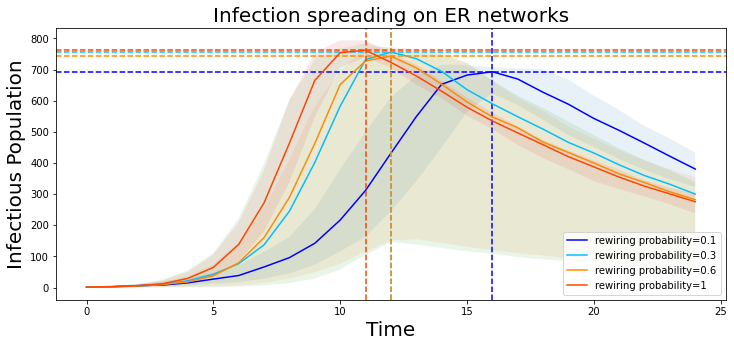

In [0]:
Infection_list=[I_WS1,I_WS3,I_WS6,I_WS10]
label_list=['rewiring probability=0.1','rewiring probability=0.3','rewiring probability=0.6','rewiring probability=1']
#color_list=['steelblue','orange','teal','salmon']
color_list=['blue','deepskyblue','darkorange','orangered']
title='Infection spreading on ER networks'
Infection_compare_plot(Infection_list,label_list,color_list,title,text_control='off')

## **Introducing two additional compartments latent and death to the original SIR model**



* beta infection rate; 
* sigma rate of progression (inverse of incubation period);
* γ: rate of recovery (inverse of infectious period)
* ξ: rate of re-susceptibility (inverse of temporary immunity period; 0 if permanent immunity)
* d: rate of mortality from the disease (deaths per infectious individual per time)
* eta: rate of re-susceptibility (inverse of temporary immunity period; 0 if permanent immunity)



In [0]:
I0=10
beta=0.155
sigma=1/5.2
mu=1/12.39
d=0.1
eta=0.01
T=300

S,E,I,R = seir_network(A_ba,I0,beta,sigma,mu,d,eta,T)
#S,E,I,R = seir_network(A_WS,I0,beta,sigma,mu,d,eta,T)

Text(0.5, 1.0, 'SEIRD model')

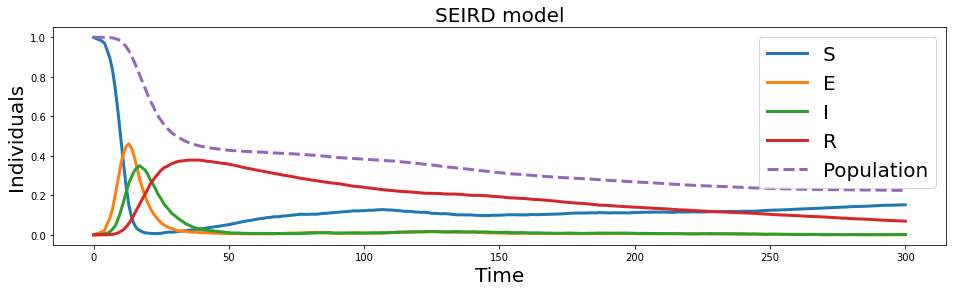

In [0]:
N=10000
fig2, ax2 = plt.subplots(figsize=(16,4))
ax2.plot(S/N, label='S', lw=3)
ax2.plot(E/N, label='E',lw=3)
ax2.plot(I/N, label='I', lw=3)
ax2.plot(R/N, label='R', lw=3)
ax2.plot((S+E+I+R)/N,  linestyle='dashed',label='Population', lw=3)
ax2.legend(fontsize=20)
ax2.set_xlabel('Time', fontsize=20)
ax2.set_ylabel('Individuals', fontsize=20)
ax2.set_title('SEIRD model', fontsize=20)


## **Build the base toy decentralised-metapopulation network for the disease to spread in. The network is simulated as the following:**
## **Initialisation: Generate nC cliques of which the number of local community nodes follows a Poisson distributin with mean mzero.** 
## **Connect the cliques with a configurable probability p**
## **At each time step, with the disease spreading model SIR being implemented simultaneously, each node could rewire its inter-community edges with a configurable parameter mobility.** 

6

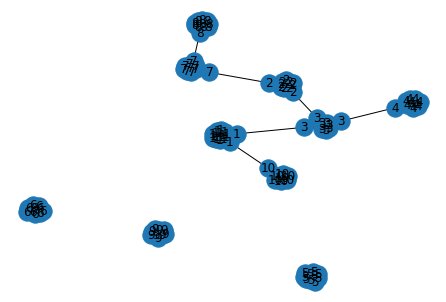

In [26]:
mzero=10# mean of initial number of nodes in each community
nC=10#number of communities, equals M in the paper
m=5#1<=m<=m0
n=1#1<=n<=m    
timestep=30
alpha=0.1
plt.close('all')

def sortbycommunity(G):
    community2nodes=defaultdict(list)
    nodes2community=defaultdict()
    dic=dict(G.nodes(data='community', default=1))
    community_list=list(set(dict(G.nodes(data='community', default=1)).values()))
    for node in G.nodes():
        c=G.nodes(data='community')[node]
        nodes2community[node]=c
        community2nodes[c].append(node)


    return nodes2community,community2nodes
        



def connect_cliques(G,nC,p,community2nodes):
    G=G.copy()
    inter_edge_set=set()
    #connect the nC cliques stochastically
    for ci in range(1,nC):
        for cj in range(ci+1,nC+1):
             if random.random()<p:
                origin=community2nodes[ci]
                target=community2nodes[cj]
                origin=random.choice(origin)
                target=random.choice(target)
                G.add_edge(origin,target)
                if origin<target:
                    inter_edge_set.add((origin,target))
                else:
                    inter_edge_set.add((target,origin))            
    return G,inter_edge_set            


def disconnect_cliques(G,inter_edge_set):
    G=G.copy()
    #connect the nC cliques stochastically
    for i,j in inter_edge_set:
        G.remove_edge(i,j)
    return G       


def rewire_inter(G,mobility,inter_edge_set,nodes2community,community2nodes):    
    new_inter_set=inter_edge_set.copy()    
    for i,j in inter_edge_set:
        if random.random()<mobility:
            G.remove_edge(i,j)
            new_inter_set.remove((i,j))
            ci=nodes2community[i]
            listc=list(range(1,nC+1))
            listc.remove(ci)
            cj=random.choice(listc)
            targets=community2nodes[cj]
            target=random.choice(targets)
            G.add_edge(i,target)
            if i<target:
                new_inter_set.add((i,target))
            else:
                new_inter_set.add((target,i))                        
    return G,new_inter_set






def build_G(mzero,nC,p,mobility=0.6):
    #mobility is just the rewiring probability in this inplementation
    G=nx.Graph()
    for c in range(1,nC+1):  
        m0=np.random.poisson(mzero-1)+1
        sizeG=len(G.nodes())
        G.add_nodes_from(range(1+sizeG,1+sizeG+m0))

        for i in range(sizeG+1,m0+sizeG+1):
            G.nodes[i]['community'] =c
            for j in range(i+1,m0+sizeG+1):
                G.add_edge(i,j)

    clique_graph = nx.freeze(G.copy())

    nodes2community,community2nodes=sortbycommunity(G) 

    #connect the nC cliques stochastically
    G,inter_edge_set=connect_cliques(G,nC,p,community2nodes)
    rewire_G,inter_edge_set=rewire_inter(G,mobility,inter_edge_set,nodes2community,community2nodes)
    #Isomorphic graphs when there is only one edge between each pair of communities
    return G,inter_edge_set,clique_graph


G,inter_edge_set,clique_graph=build_G(mzero,nC,p=0.1,mobility=0.6)
nx.draw(G, with_labels=True,labels=nx.get_node_attributes(G, 'community'))
len(inter_edge_set)



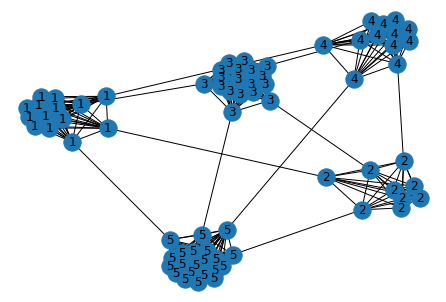

In [28]:
T=10
mzero=15
nC=5
mobility=1
G=nx.Graph()

for c in range(1,nC+1):  
    m0=np.random.poisson(mzero-1)+1
    sizeG=len(G.nodes())
    G.add_nodes_from(range(1+sizeG,1+sizeG+m0))

    for i in range(sizeG+1,m0+sizeG+1):
        G.nodes[i]['community'] =c
        for j in range(i+1,m0+sizeG+1):
          
            G.add_edge(i,j)

clique_graph = nx.freeze(G.copy())

nodes2community,community2nodes=sortbycommunity(G) 

#connect the nC cliques stochastically
p=1
G,inter_edge_set=connect_cliques(G,nC,p,community2nodes)
#print(inter_edge_set)
nx.draw(G, with_labels=True,labels=nx.get_node_attributes(G, 'community'))




In [0]:
def sir_moving_network(mzero,nC,p,mobility,I0,beta,mu,T):
    S = np.zeros(T+1)
    I = np.zeros(T+1)
    R = np.zeros(T+1)  
    G,inter_edge_set,clique_graph=build_G(mzero,nC,p,mobility)
    N = len(G.nodes())
    S[0] = N-I0
    I[0] = I0 
    nodes2community,community2nodes=sortbycommunity(G)     
    node_status = {node:{'current_status':'S', 'next_status':None} for node in range(N)}    
    init_infected = np.random.permutation(N)[:I0]
    for node in init_infected:
        node_status[node]['current_status'] = 'I'
        
    for t in range(1,T+1):
        S[t] = S[t-1]
        I[t] = I[t-1]
        R[t] = R[t-1]
        
        rewireG,inter_edge_set=rewire_inter(G,mobility,inter_edge_set,nodes2community,community2nodes)
        #rewireG,inter_edge_list=connect_cliques(clique_graph,nC,community2nodes)

        
        A=nx.adjacency_matrix(rewireG)
        
        G=rewireG.copy()

        for node in range(N):
            if node_status[node]['current_status']=='S':
                for neigh in A[node].indices:
                    if node_status[neigh]['current_status']=='I':
                        if np.random.rand()<beta:
                            node_status[node]['next_status']='I'
                            S[t] -= 1
                            I[t] += 1
                            break
            elif node_status[node]['current_status']=='I':
                if np.random.rand()<mu:
                    node_status[node]['next_status']='R'
                    R[t] += 1
                    I[t] -= 1

        for node in range(N):
            if node_status[node]['next_status']:
                node_status[node]['current_status'] = node_status[node]['next_status']
                node_status[node]['next_status'] = None
            
    return S,I,R

Text(0, 0.5, 'Infectious population')

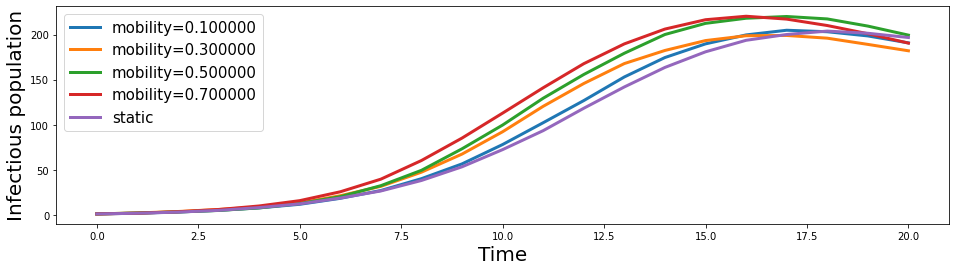

In [41]:
mzero=4
nC=100
p=0.1
T=20
I0=1


_,I_static,_=sir_moving_network(mzero,nC,p,0,I0,beta,mu,T)




rep=50


for m in [0.1,0.3,0.5,0.7]:

    String = "_,I_%s,_ =sir_moving_network(mzero,nC,p,%f,I0,beta,mu,T) "%(int(10*m), m)
    exec(String) 

for r in range(rep-1):
    for m in [0.1,0.3,0.5,0.7]:
        String = "_,I,_ =sir_moving_network(mzero,nC,p,%f,I0,beta,mu,T) "%( m)
        exec(String)
        String = "I_%s +=I "%(int(10*m))
        exec(String)





fig3, ax3 = plt.subplots(figsize=(16,4))

_,I_static,_ =sir_moving_network(mzero,nC,p,0,I0,beta,mu,T) 

for r in range(rep-1):
    String = "_,I,_ =sir_moving_network(mzero,nC,p,0,I0,beta,mu,T) "
    exec(String)
    I_static +=I 

I_static/=rep



for m in [0.1,0.3,0.5,0.7]:
    String = "I_%s/=rep "%(int(10*m))

    exec(String)        


    String = "ax3.plot(I_%s, label='mobility=%f', lw=3) "%(int(10*m), m)
    exec(String)        

        
ax3.plot(I_static, label='static', lw=3)


ax3.legend(fontsize=15)

#ax3.set_xlim(0,10)
ax3.set_xlabel('Time', fontsize=20)
ax3.set_ylabel('Infectious population', fontsize=20)



In [0]:
def moving_network(mzero,nC,p,mobility,T):

    G,inter_edge_set,clique_graph=build_G(mzero,nC,p,mobility)
    nodes2community,community2nodes=sortbycommunity(G) 
    A_list=[]  

    for t in range(1,T+1):

        rewireG,inter_edge_set=rewire_inter(G,mobility,inter_edge_set,nodes2community,community2nodes)
        #rewireG,inter_edge_list=connect_cliques(clique_graph,nC,community2nodes)

        
        A=nx.adjacency_matrix(rewireG)
        A_list.append(A)

        G=rewireG.copy()

 
    return A_list

mzero=4
nC=100
p=0.1
T=20
I0=1

mobility=[0.1,0.3,0.5,0.7,0.9,1]
T=10
for m in mobility:
    #compute the first run and then average for static network 
    String = "A_list_%s =moving_network(mzero,nC,p,%f,T) "%(int(10*m),m)
    exec(String)





Text(0.5, 0.98, 'Degree distribution with varying mobility')

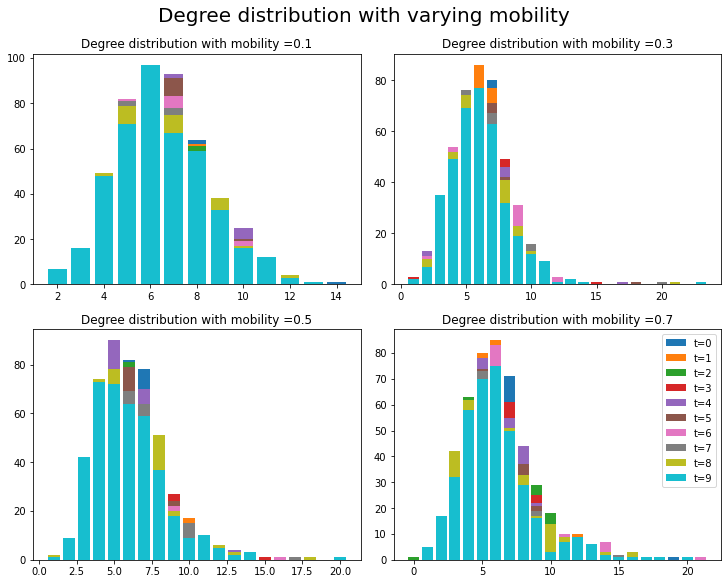

In [43]:
mobility=[0.1,0.3,0.5,0.7]
rows=2
cols=2
figsize=(10,8)

fig, axs = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)
axs = trim_axs(axs, len(mobility))


for ax, m in zip(axs, mobility):
    ax.set_title('Degree distribution with mobility =%s' % str(m))
    String = "A_list=A_list_%s"%(int(10*m))
    exec(String)
    for t in range(T):
        
        deglist=get_degrees(A_list[t])

        unique, counts = np.unique(deglist, return_counts=True)
        String = "ax.bar(unique, counts, align='center',label='t=%s', alpha=1)"%(t)
        exec(String)

                 
ax.legend(fontsize=10)
fig.suptitle('Degree distribution with varying mobility', fontsize=20)


Text(0.5, 0.98, 'Degree distribution with varying mobility')

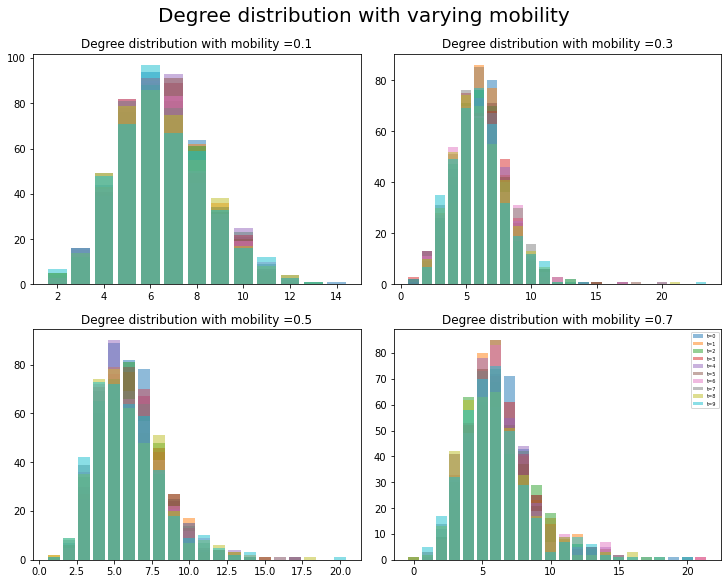

In [44]:
mobility=[0.1,0.3,0.5,0.7,0.9,1]

fig, axs = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)
axs = trim_axs(axs, len(mobility))


for ax, m in zip(axs, mobility):
    ax.set_title('Degree distribution with mobility =%s' % str(m))
    String = "A_list=A_list_%s"%(int(10*m))
    exec(String)
    for t in range(T):
        
        deglist=get_degrees(A_list[t])

        unique, counts = np.unique(deglist, return_counts=True)
        String = "ax.bar(unique, counts, align='center',label='t=%s', alpha=.5)"%(t)
        exec(String)

                 
ax.legend(fontsize=5)
fig.suptitle('Degree distribution with varying mobility', fontsize=20)


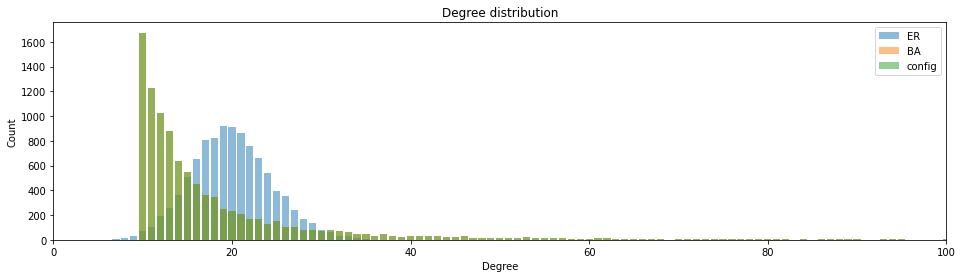

In [45]:
ER_unique, ER_counts = np.unique(deg_ER, return_counts=True)
ba_unique, ba_counts = np.unique(deg_ba, return_counts=True)
config_unique, config_counts = np.unique(deg_config, return_counts=True)

fig, ax = plt.subplots(figsize=(16,4))
ax.bar(ER_unique, ER_counts, align='center', alpha=0.5,label="ER")
ax.bar(ba_unique, ba_counts, align='center', alpha=0.5,label="BA")
ax.bar(config_unique, config_counts, align='center', alpha=0.5,label="config")

ax.set_xlabel('Degree')
ax.set_ylabel('Count')
ax.set_xlim(0,100)
ax.set_title('Degree distribution')

ax.legend()
plt.show()

In [0]:
mzero=4
nC=1000
p=1
T=15
I0=10
rep=1

_,I_static,_=sir_moving_network(mzero,nC,p,0,I0,beta,mu,T)

#format I_interprob_mobility

for p in [0.1,0.3,0.5,0.7,0.9,1]:
    #compute the first run and then average for static network
    String = "_,I_%s_static,_ =sir_moving_network(mzero,nC,%f,0,I0,beta,mu,T) "%(int(10*p),p)
    exec(String)
    
    for r in range(rep-1):
        String = "_,I,_ =sir_moving_network(mzero,nC,%f,0,I0,beta,mu,T) "%(p)
        exec(String)
        String = "I_%s_static+=I"%(int(10*p))
        exec(String)
    String = "I_%s_static/=rep"%(int(10*p))
    exec(String)

    
    #compute the first run for p, m
    for m in [0.1,0.3,0.5,0.7]:
        String = "_,I_%s_%s,_ =sir_moving_network(mzero,nC,%f,%f,I0,beta,mu,T) "%(int(10*p),int(10*m),p, m)
        exec(String) 


    #compute the average
    for r in range(rep-1):
        for m in [0.1,0.3,0.5,0.7]:
            String = "_,I,_ =sir_moving_network(mzero,nC,%f,%f,I0,beta,mu,T) "%(p, m)
            exec(String)
            String = "I_%s_%s +=I "%(int(10*p),int(10*m))
            exec(String)
            String = "I_%s_%s/=rep "%(int(10*p),int(10*m))
            exec(String)








Text(0.5, 0.98, 'Degree distribution with varying mobility, number of communities=1000,m0=4')

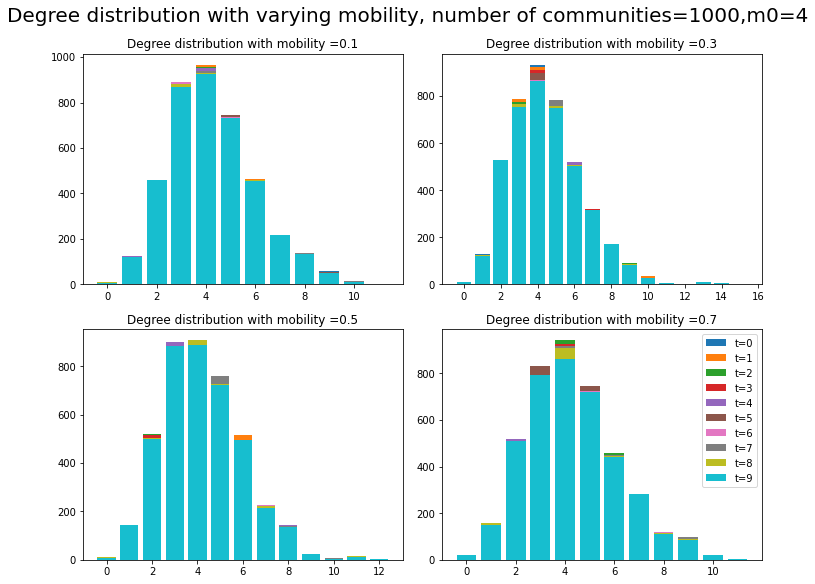

In [238]:
mobility= [0.1,0.3,0.5,0.7]
T=10
mzero=4
nC=1000
for m in mobility:
    #compute the first run and then average for static network 
    String = "A_list_%s =moving_network(mzero,nC,p,%f,T) "%(int(10*m),m)
    exec(String)
rows=2
cols=2
figsize=(10,8)
fig, axs = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)
axs = trim_axs(axs, len(mobility))


for ax, m in zip(axs, mobility):
    ax.set_title('Degree distribution with mobility =%s' % str(m))
    String = "A_list=A_list_%s"%(int(10*m))
    exec(String)
    for t in range(T):
        
        deglist=get_degrees(A_list[t])

        unique, counts = np.unique(deglist, return_counts=True)
        String = "ax.bar(unique, counts, align='center',label='t=%s', alpha=1)"%(t)
        exec(String)

                 
ax.legend(fontsize=10)
fig.suptitle('Degree distribution with varying mobility, number of communities=%i,m0=%i'%(nC,mzero), fontsize=20)

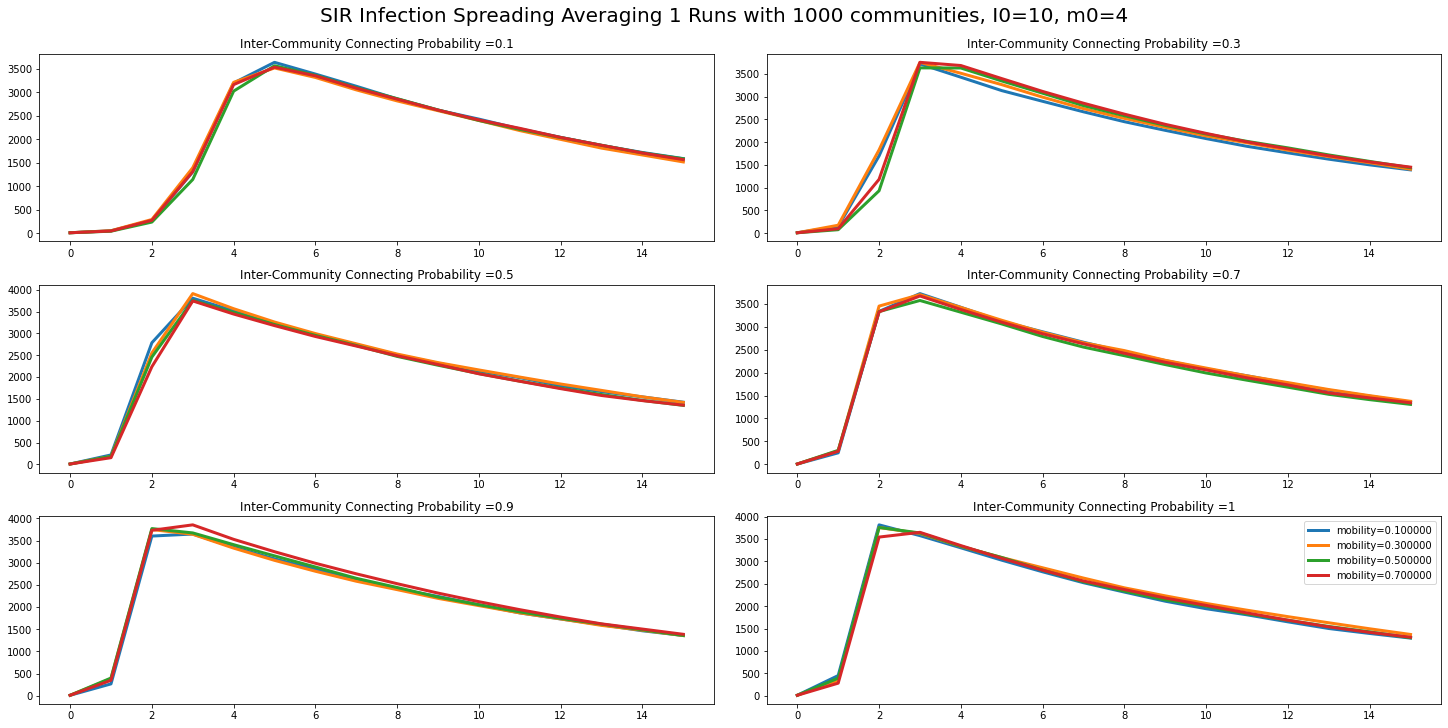

In [0]:
p = [0.1,0.3,0.5,0.7,0.9,1]
figsize = (20, 10)
rows=3
cols=2

fig, axs = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)

axs = trim_axs(axs, len(p))


for ax, p in zip(axs, p):
    ax.set_title('Inter-Community Connecting Probability =%s' % str(p))
    

    for m in [0.1,0.3,0.5,0.7]:
 
        String = "ax.plot(I_%s_%s, label='mobility=%f', lw=3) "%(int(10*p),int(10*m), m)
        exec(String)   
        
ax.legend(fontsize=10)

String = "fig.suptitle('SIR Infection Spreading Averaging %s Runs with %s communities, I0=%s, m0=%s', fontsize=20)"%(rep,nC,I0,mzero)
exec(String) 



Text(0, 0.5, 'Infectious population')

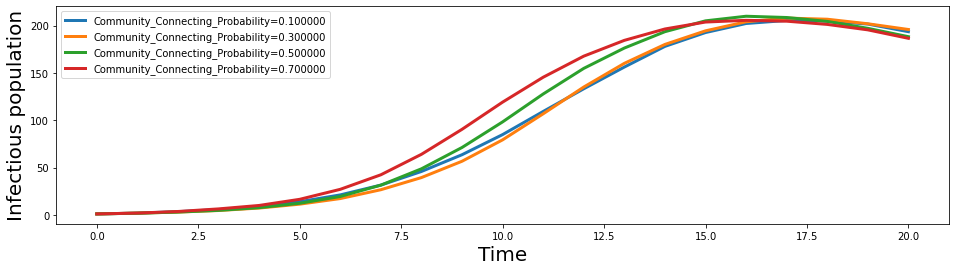

In [0]:
fig4, ax4 = plt.subplots(figsize=(16,4))

for p in [0.1,0.3,0.5,0.7]:
    String = "ax4.plot(I_%s, label='Community_Connecting_Probability=%f', lw=3) "%(int(10*p), p)
    exec(String)

ax4.legend(fontsize=10)

#ax3.set_xlim(0,10)
ax4.set_xlabel('Time', fontsize=20)
ax4.set_ylabel('Infectious population', fontsize=20)


## Build a network that incorporates Hierarchical structures and a function sir_hier_attack that immunised the top-degree node at each time step while modelling disease spreading under SIR

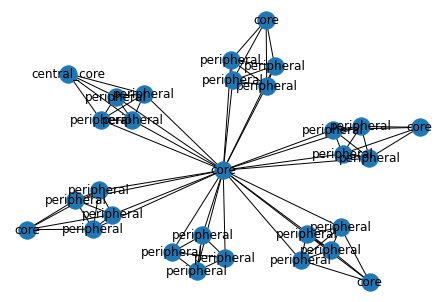

In [46]:
#Create the hierarchical network
hierNet=nx.complete_graph(5)
hierNet.nodes[0]['class']='central_core'
for i in range(1,5):
    hierNet.nodes[i]['class']='peripheral'

for level in range(1,2):
    replicas=[hierNet.copy() for i in range(5)]
    for replica in replicas:
        replica.nodes[0]['class']='core'
    merge=replicas+[hierNet]   
    hierNet=nx.disjoint_union_all(merge)
    
    for node in hierNet.nodes():
        if hierNet.nodes[node].get('class')=='peripheral':
            hierNet.add_edge(0,node)
nx.draw(hierNet, with_labels=True,labels=nx.get_node_attributes(hierNet, 'class'))
 

In [0]:
def HierNet(mzero,n_copy,level):
    #Create the hierarchical network
    HierNet=nx.complete_graph(mzero)
    HierNet.nodes[0]['class']='central_core'
    for i in range(1,mzero):
        HierNet.nodes[i]['class']='peripheral'

    for l in range(1,level):
        replicas=[HierNet.copy() for i in range(n_copy)]
        for replica in replicas:
            replica.nodes[0]['class']='core'
        merge=replicas+[HierNet]   
        HierNet=nx.disjoint_union_all(merge)
      
        for node in HierNet.nodes():
            if HierNet.nodes[node].get('class')=='peripheral':
                HierNet.add_edge(0,node)
    return HierNet
  



def sir_hier_attack(mzero,n_copy,level,I0,beta,mu,T,rep=10,attack='degree'):
    hierNet=HierNet(mzero,n_copy,level)
    G=hierNet


    degreeArray_hier=np.array([hierNet.degree(i) for i in hierNet])
    S = np.zeros((T,rep))
    I = np.zeros((T,rep))
    R = np.zeros((T,rep))
    
    
    N = len(G.nodes())

    S[0,:] = N-I0
    I[0,:] = I0
    R[0,:] = 0
    G=hierNet

    
    for r in range(rep):


        node_status = {node:{'current_status':'S', 'next_status':None} for node in range(N)}    
        init_infected = np.random.permutation(N)[:I0]
        for node in init_infected:
            node_status[node]['current_status'] = 'I'

        for t in range(1,T):
            S[t,r] = S[t-1,r]
            I[t,r] = I[t-1,r]
            R[t,r] = R[t-1,r]
            if attack == 'degree':
                node_attack=np.argmax(degreeArray_hier)
            if attack =='random':  
                node_attack=np.random.choice(N)

            degreeArray_hier[node_attack]=-1
            degreeArray_hier[list(hierNet.neighbors(node_attack))]-=1
            hierNet.remove_node(node_attack)
            A=nx.adjacency_matrix(hierNet)
            N-=1
            for node in range(N):
                if node_status[node]['current_status']=='S':
                    for neigh in A[node].indices:
                        if node_status[neigh]['current_status']=='I':
                            if np.random.rand()<beta:
                                node_status[node]['next_status']='I'
                                S[t,r] -= 1
                                I[t,r] += 1
                                break
                elif node_status[node]['current_status']=='I':
                    if np.random.rand()<mu:
                        node_status[node]['next_status']='R'
                        R[t,r] += 1
                        I[t,r] -= 1

            for node in range(N):
                if node_status[node]['next_status']:
                    node_status[node]['current_status'] = node_status[node]['next_status']
                    node_status[node]['next_status'] = None

    return S,I,R






In [48]:
mzero=4
level=6
n_copy=5
hier=HierNet(mzero,n_copy,level)
A_hier = nx.adjacency_matrix(hier)
print('Size of the Hierarchy Network',len(hier.nodes()))



Size of the Hierarchy Network 31104


In [0]:
T=20
S_hier_attack,I_hier_attack,R_hier_attack=sir_hier_attack(mzero,n_copy,level,I0,beta,mu,T)
S_hier,I_hier,R_hier=sir_network(A_hier,I0,beta,mu,T)

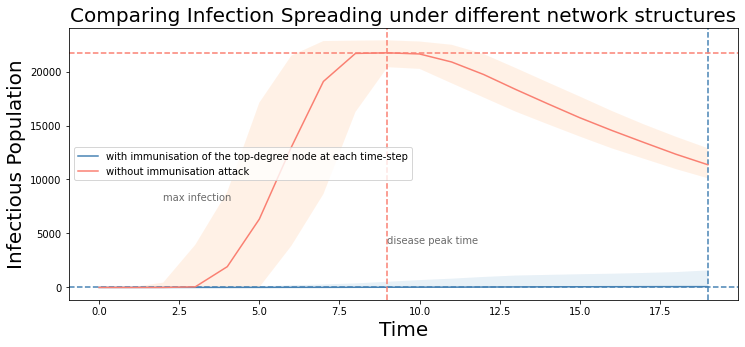

In [50]:

#color_list=['steelblue','orange','teal','salmon']

Infection_list=[I_hier_attack,I_hier]
label_list=['with immunisation of the top-degree node at each time-step','without immunisation attack']
color_list=['steelblue','salmon']

Infection_compare_plot(Infection_list,label_list,color_list,text_control='on')



In [51]:
print('Size of the Hierarchy Network',len(hier.nodes()))

Size of the Hierarchy Network 31104


In [0]:
T=10
N=len(hier.nodes())
I0=int(N/10)
S_hier_attack,I_hier_attack,R_hier_attack=sir_hier_attack(mzero,n_copy,level,I0,beta,mu,T)
S_hier,I_hier,R_hier=sir_network(A_hier,I0,beta,mu,T)

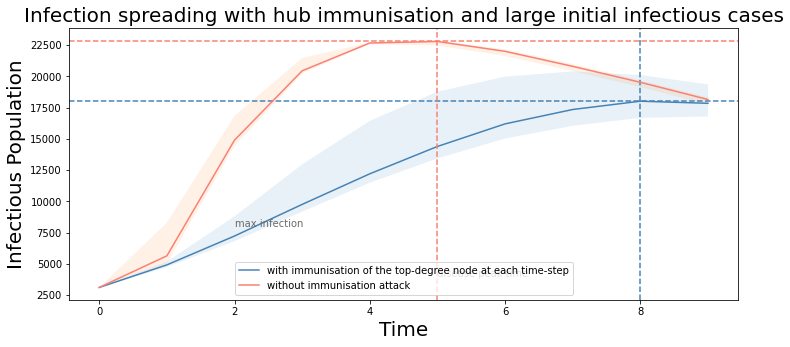

In [53]:

#color_list=['steelblue','orange','teal','salmon']

Infection_list=[I_hier_attack,I_hier]
label_list=['with immunisation of the top-degree node at each time-step','without immunisation attack']
color_list=['steelblue','salmon']
title='Infection spreading with hub immunisation and large initial infectious cases'
Infection_compare_plot(Infection_list,label_list,color_list,title,text_control='on')



In [0]:
T=10
N=len(hier.nodes())
I0=int(N/2)
S_hier_degree,I_hier_degree,R_hier_degree=sir_hier_attack(mzero,n_copy,level,I0,beta,mu,T)
S_hier,I_hier,R_hier=sir_network(A_hier,I0,beta,mu,T)
S_hier_random,I_hier_random,R_hier_random=sir_hier_attack(mzero,n_copy,level,I0,beta,mu,T,rep=10,attack='random')


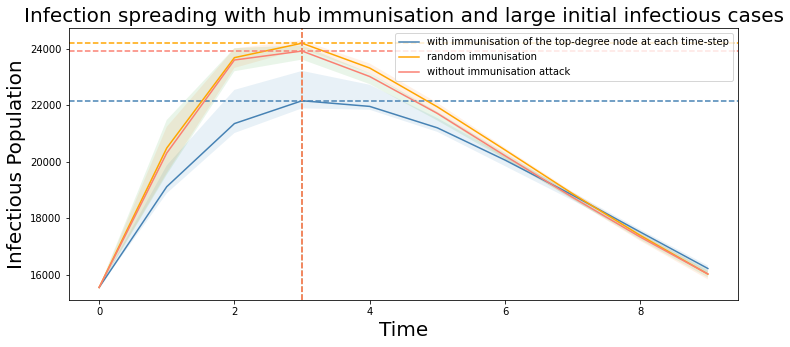

In [55]:

#color_list=['steelblue','orange','teal','salmon']

Infection_list=[I_hier_degree,I_hier_random,I_hier]
label_list=['with immunisation of the top-degree node at each time-step','random immunisation','without immunisation attack']
color_list=['steelblue','orange','salmon']
title='Infection spreading with hub immunisation and large initial infectious cases'
Infection_compare_plot(Infection_list,label_list,color_list,title,text_control='off')

